In a new python environment with python>=3.10

In [ ]:
!pip install "torch_uncertainty[image] @ git+https://github.com/ENSTA-U2IS-AI/torch-uncertainty@dev"

In [ ]:
# here are the training parameters
batch_size = 10
learning_rate =1e-3
weight_decay=2e-4
lr_decay_epochs=20
lr_decay=0.1
nb_epochs=50

In [ ]:
import torch
from einops import rearrange
from torchvision import tv_tensors
from torchvision.transforms import v2
from torchvision.transforms.v2 import functional as F

from torch_uncertainty.datasets import MUAD

train_transform = v2.Compose(
    [
        v2.Resize(size=(256, 512), antialias=True),
        v2.RandomHorizontalFlip(),
        v2.ToDtype(
            dtype={
                tv_tensors.Image: torch.float32,
                tv_tensors.Mask: torch.int64,
                "others": None,
            },
            scale=True,
        ),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        v2.Resize(size=(256, 512), antialias=True),
        v2.ToDtype(
            dtype={
                tv_tensors.Image: torch.float32,
                tv_tensors.Mask: torch.int64,
                "others": None,
            },
            scale=True,
        ),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

train_set = MUAD(root="./data", target_type="semantic", version="small", split="train" , transforms=train_transform, download=True)
val_set = MUAD(root="./data", target_type="semantic", version="small", split="val" , transforms=val_transform, download=True)
test_set = MUAD(root="./data", target_type="semantic", version="small", split="test" , transforms=val_transform, download=True)

Let us see the first sample of the validation set. The first image is the input and the second image is the target (ground truth).

In [ ]:
sample = train_set[0]
img, tgt = sample
img.size(), tgt.size()

(torch.Size([3, 256, 512]), torch.Size([1, 256, 512]))

Visualize a validation input sample (and RGB image)

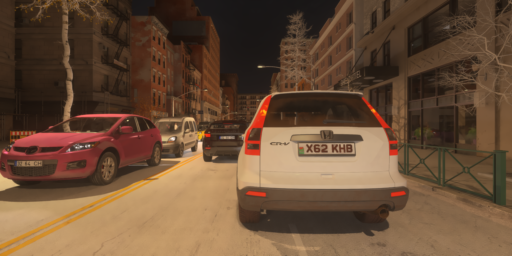

In [ ]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)
F.to_pil_image(img)

Visualize the same image above but segmented (our goal)

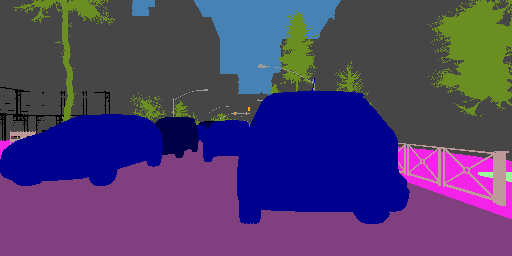

In [ ]:
from torchvision.utils import draw_segmentation_masks

tmp_tgt = tgt.masked_fill(tgt == 255, 21)
tgt_masks = tmp_tgt == torch.arange(22, device=tgt.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, tgt_masks, alpha=1, colors=val_set.color_palette)
F.to_pil_image(img_segmented)

Below is the complete list of classes in MUAD, presented as:

1.   Class Name
2.   Train ID
3.   Segmentation Color in RGB format [R,G, B].

In [ ]:
for muad_class in train_set.classes:
    class_name = muad_class.name
    train_id = muad_class.id
    color = muad_class.color
    print(f"Class: {class_name}, Train ID: {train_id}, Color: {color}")

Class: road, Train ID: 0, Color: (128, 64, 128)
Class: sidewalk, Train ID: 1, Color: (244, 35, 232)
Class: building, Train ID: 2, Color: (70, 70, 70)
Class: wall, Train ID: 3, Color: (102, 102, 156)
Class: fence, Train ID: 4, Color: (190, 153, 153)
Class: pole, Train ID: 5, Color: (153, 153, 153)
Class: traffic_light, Train ID: 6, Color: (250, 170, 30)
Class: traffic_sign, Train ID: 7, Color: (220, 220, 0)
Class: vegetation, Train ID: 8, Color: (107, 142, 35)
Class: terrain, Train ID: 9, Color: (152, 251, 152)
Class: sky, Train ID: 10, Color: (70, 130, 180)
Class: person, Train ID: 11, Color: (220, 20, 60)
Class: car, Train ID: 13, Color: (0, 0, 142)
Class: truck, Train ID: 14, Color: (0, 0, 70)
Class: bus, Train ID: 15, Color: (0, 60, 100)
Class: rider, Train ID: 12, Color: (255, 0, 0)
Class: train, Train ID: 16, Color: (0, 80, 100)
Class: motorcycle, Train ID: 17, Color: (0, 0, 230)
Class: bicycle, Train ID: 18, Color: (119, 11, 32)
Class: bear deer cow, Train ID: 19, Color: (255, 22

Here is a more comprhensive review of the diffrent classes : (while training Non-labeled data will use train ID 21 and not 255)


| **class names**                       | **ID** |
|----------------------------------------|---------|
| road                                   | 0       |
| sidewalk                               | 1       |
| building                               | 2       |
| wall                                   | 3       |
| fence                                  | 4       |
| pole                                   | 5       |
| traffic light                          | 6       |
| traffic sign                           | 7       |
| vegetation                             | 8       |
| terrain                                | 9       |
| sky                                    | 10      |
| person                                 | 11      |
| rider                                  | 12      |
| car                                    | 13      |
| truck                                  | 14      |
| bus                                    | 15      |
| train                                  | 16      |
| motorcycle                             | 17      |
| bicycle                                | 18      |
| bear deer cow                          | 19      |
| garbage_bag stand_food trash_can       | 20      |


We will feed our DNN the first raw image of the road view and as target it will be the dark image below and not the colored one (second image)

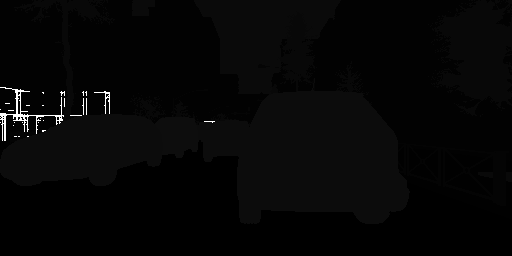

In [ ]:
im = F.to_pil_image(F.to_dtype(tgt, torch.uint8))
im

In [ ]:
im.size

(512, 256)

**Why is the target image dark and what's the bright part ?** **(hint : print the numpy array)**

The target image appears almost entirely dark because its pixel values represent class IDs, not actual color intensities. Each pixel stores an integer corresponding to a semantic class (e.g., 0 for road, 2 for building, 10 for sky, 13 for car, etc.). Since these values range from 0 to 21, they are extremely low compared to the full 0–255 grayscale range, which is why the image looks nearly black when displayed as a standard image.

The brighter areas visible in the target image correspond to pixels with higher class IDs. For instance, the car silhouettes appear as the most distinguishable shapes because the "car" class has a train ID of 13, which is slightly brighter. The small bright spots and patterns on the left side of the image likely correspond to classes with even higher IDs, such as bicycle (18), bear/deer/cow (19), garbage-related objects (20), or unlabeled pixels (originally 255). The road (ID 0) and sidewalk (ID 1) are virtually indistinguishable from pure black since their values are so close to zero.

This is why the colored segmentation map (using the dataset's color palette) is necessary for human visualization, while the raw ID map is what the network actually learns to predict.

**Q3/ please study the dataset a bit. What it is about?**



MUAD (Multiple Uncertainties for Autonomous Driving) is a synthetic dataset designed for semantic segmentation in the context of autonomous driving. The images are generated from a simulator, which explains the slightly artificial rendering visible in the RGB samples (e.g., the car license plates, the building textures, the tree models).

The dataset contains urban driving scenes where each pixel is annotated with one of 21 semantic classes covering the typical elements encountered on the road: infrastructure (road, sidewalk, building, wall, fence), street furniture (pole, traffic light, traffic sign), nature (vegetation, terrain, sky), road users (person, rider, car, truck, bus, train, motorcycle, bicycle), and notably some anomaly classes (bear/deer/cow, garbage bag/stand food/trash can) that are unusual objects not typically found in standard driving datasets.

The dataset is split into train, validation, test, and OOD (Out-Of-Distribution) sets. The OOD split is particularly interesting as it contains scenes with anomalous objects (such as animals on the road), which allows evaluating how well a model handles unexpected situations — a critical capability for safe autonomous driving.

Images are resized to 256×512 pixels, and the target masks encode class labels as integer IDs (0–21, with 255 for unlabeled pixels). The dataset is provided through the torch_uncertainty library, which highlights its primary purpose: serving as a benchmark not only for segmentation accuracy but also for uncertainty estimation methods in safety-critical applications.

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader

train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4)

val_loader = DataLoader(
        val_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4)

test_loader = DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
def enet_weighing(dataloader, num_classes, c=1.02):
    """Computes class weights as described in the ENet paper.

        w_class = 1 / (ln(c + p_class)),

    where c is usually 1.02 and p_class is the propensity score of that
    class:

        propensity_score = freq_class / total_pixels.

    References:
        https://arxiv.org/abs/1606.02147

    Args:
        dataloader (``data.Dataloader``): A data loader to iterate over the
            dataset.
        num_classes (``int``): The number of classes.
        c (``int``, optional): AN additional hyper-parameter which restricts
            the interval of values for the weights. Default: 1.02.

    """
    class_count = 0
    total = 0
    for _, label in dataloader:
      label = label.cpu().numpy()
      # Flatten label
      flat_label = label.flatten()
      flat_label = flat_label[flat_label != 255]

      # Sum up the number of pixels of each class and the total pixel
      # counts for each label
      class_count += np.bincount(flat_label, minlength=num_classes)
      total += flat_label.size

    # Compute propensity score and then the weights for each class
    propensity_score = class_count / total
    return 1 / (np.log(c + propensity_score))

In [ ]:
print("\nComputing class weights...")
print("(this can take a while depending on the dataset size)")
class_weights = enet_weighing(train_loader, 19)
class_weights = torch.from_numpy(class_weights).float().cuda()
print("Class weights:", class_weights)


Computing class weights...
(this can take a while depending on the dataset size)
Class weights: tensor([ 4.1643, 18.8984,  3.2313, 48.7521, 34.9159, 33.8659, 46.7701, 49.3670,
        12.2677, 48.3328, 14.2019, 32.0444,  5.2256, 21.1894, 50.4983, 50.4983,
        50.4983, 50.4983, 50.4983], device='cuda:0')


**Q4/ why do we need to evaluate the class_weights?**

In semantic segmentation, the class distribution is typically highly imbalanced. In a driving scene, classes like "road" and "building" occupy a very large portion of the image, while classes like "motorcycle", "bus", "train", or "bicycle" appear in only a few pixels — or may not appear at all in some images.

This is clearly confirmed by the computed weights: "road" has a weight of 4.16 (very frequent, so low weight), "building" gets 3.23, while rare classes like truck, bus, train, motorcycle, and bicycle all receive the maximum weight of ~50.5 (extremely rare). Without balancing, the model would optimize primarily for dominant classes and largely ignore minority classes, since predicting "road" everywhere would already yield a low loss.

The ENet weighting scheme addresses this by assigning each class a weight inversely proportional to its frequency: w = 1 / ln(c + p_class), where p_class is the proportion of pixels belonging to that class. The hyperparameter c = 1.02 prevents the weights from exploding for very rare classes. These weights are then passed to the CrossEntropyLoss criterion so that misclassifying a rare pixel (e.g., a motorcycle) is penalized much more heavily than misclassifying a common pixel (e.g., road). This encourages the model to learn meaningful representations for all classes, which is essential for safety-critical applications like autonomous driving where detecting a rare pedestrian or bicycle is just as important as recognizing the road.

## C. building the DNN

**Q5/ Do we really use Unet? What did I change :)? (that is hard)**


**Q6/Do we need a backbone with Unet?**






Question 5

This architecture is based on UNet but includes two notable modifications compared to the original:1. Bilinear upsampling instead of transposed convolutions. In the original UNet, the upsampling path uses ConvTranspose2d (learned deconvolutions).
Here, the Up blocks default to bilinear=True, which means the feature maps are upsampled using bilinear interpolation (F.resize with BILINEAR mode) instead of learned transposed convolutions. This reduces the number of trainable parameters and avoids the checkerboard artifacts that transposed convolutions are known to produce.2. Dropout2d layers in the decoder. The original UNet does not include dropout.
Here, a Dropout2d(0.1) layer is applied after each upsampling block in the forward pass. This is not just for regularization — it is a deliberate design choice to enable MC Dropout (Monte Carlo Dropout) at inference time later in the lab. By keeping dropout active during testing and running multiple forward passes, we can estimate the model's predictive uncertainty.Additionally, the channel dimensions are smaller than the original UNet (starting at 32 instead of 64), and the bottleneck keeps the same number of channels (256→256) instead of doubling, making this a lighter version of UNet.

Question 6

No, UNet does not require a pretrained backbone. Unlike architectures such as DeepLabV3 or FCN, which typically rely on a pretrained encoder (e.g., ResNet, VGG) as a feature extractor, UNet is designed to be trained from scratch end-to-end. Its symmetric encoder-decoder structure with skip connections allows it to learn both low-level and high-level features directly from the data.

That said, in practice, using a pretrained backbone as the encoder of a UNet (e.g., ResNet-34 encoder) can improve performance and convergence speed, especially when training data is limited. This is the principle behind architectures like LinkNet or encoder-decoder variants in the segmentation literature. However, in this lab, the UNet is fully trained from scratch with its own convolutional encoder, which keeps the architecture simple and self-contained.


In [ ]:
from torch import nn


class DoubleConv(nn.Module):
    """(conv => BN => ReLU) * 2."""

    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class InConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        return self.conv(x)


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        return self.mpconv(x)


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        self.bilinear = bilinear

        self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        if self.bilinear:
            x1 = F.resize(x1, size=[2*x1.size()[2],2*x1.size()[3]],
                          interpolation=v2.InterpolationMode.BILINEAR)
        else:
            x1 = self.up(x1)

        # input is CHW
        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2,
                        diff_y // 2, diff_y - diff_y // 2])

        # for padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        return self.conv(x)

#please note that we have added dropout layer to be abble to use MC dropout

class UNet(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.inc = InConv(3, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 256)
        self.up1 = Up(512, 128)
        self.up2 = Up(256, 64)
        self.up3 = Up(128, 32)
        self.up4 = Up(64, 32)
        self.dropout = nn.Dropout2d(0.1)
        self.outc = OutConv(32, classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.dropout(x)
        x = self.up2(x, x3)
        x = self.dropout(x)
        x = self.up3(x, x2)
        x = self.dropout(x)
        x = self.up4(x, x1)
        x = self.dropout(x)
        return self.outc(x)

## D. Utility functions

In [ ]:
import matplotlib.pyplot as plt

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.title("Evolution of the training and validation loss")
    plt.show()

def plot_accu(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training miou", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation miou", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Mean IoU")
    plt.legend(loc="upper right")
    plt.title("Evolution of Miou")
    plt.show()

**Q7/  what is the IoU?**


IoU (Intersection over Union), also known as the Jaccard Index, is the standard evaluation metric for semantic segmentation. For a given class, it is defined as:

IoU = TP / (TP + FP + FN)

where TP (True Positives) is the number of pixels correctly predicted as that class, FP (False Positives) is the number of pixels incorrectly predicted as that class, and FN (False Negatives) is the number of pixels that belong to that class but were predicted as something else.

IoU measures the overlap between the predicted segmentation and the ground truth. A value of 1.0 means perfect agreement, while 0.0 means no overlap at all.

The Mean IoU (mIoU) is simply the average IoU across all classes, and it is the primary metric used in segmentation benchmarks because, unlike pixel accuracy, it is robust to class imbalance — a model that predicts only "road" everywhere would have a high pixel accuracy but a very low mIoU since all other classes would score 0.

### Training function

**Q8/Please complete the training and the test function**

In [ ]:
from torchmetrics.utilities.compute import _safe_divide

def train(model, data_loader, optim, criterion, metric, iteration_loss=False):
    model.train()
    epoch_loss = 0.0
    metric.reset()
    for step, batch_data in enumerate(data_loader):
        # Get the inputs and labels
        img = batch_data[0].cuda()
        labels = batch_data[1].cuda()

        # Forward propagation
        outputs = model(img)

        # Loss computation
        flatten_logits = outputs.permute(0, 2, 3, 1).reshape(-1, outputs.shape[1])
        flatten_labels = labels.flatten()
        valid_mask = flatten_labels != 255
        loss = criterion(flatten_logits[valid_mask], flatten_labels[valid_mask])

        # Backpropagation
        optim.zero_grad()
        loss.backward()
        optim.step()

        # Keep track of loss for current epoch
        epoch_loss += loss.item()

        # Keep track of the evaluation metric
        metric.update(flatten_logits[valid_mask].detach(), flatten_labels[valid_mask].detach())

        if iteration_loss:
            print("[Step: %d] Iteration loss: %.4f" % (step, loss.item()))

    # Compute IoU per class
    tp, fp, _, fn = metric._final_state()
    iou_per_class = _safe_divide(tp, tp + fp + fn, zero_division=float("nan"))

    return epoch_loss / len(data_loader), iou_per_class, metric.compute()

### Validation function

In [ ]:
def test(model, data_loader, criterion, metric, iteration_loss=False):
    model.eval()
    epoch_loss = 0.0
    metric.reset()
    for step, batch_data in enumerate(data_loader):
        # Get the inputs and labels
        img = batch_data[0].cuda()
        labels = batch_data[1].cuda()

        with torch.no_grad():
            # Forward propagation
            outputs = model(img)

            # Loss computation
            flatten_logits = outputs.permute(0, 2, 3, 1).reshape(-1, outputs.shape[1])
            flatten_labels = labels.flatten()
            valid_mask = flatten_labels != 255
            loss = criterion(flatten_logits[valid_mask], flatten_labels[valid_mask])

        # Keep track of loss for current epoch
        epoch_loss += loss.item()

        # Keep track of evaluation the metric
        metric.update(flatten_logits[valid_mask], flatten_labels[valid_mask])

        if iteration_loss:
            print("[Step: %d] Iteration loss: %.4f" % (step, loss.item()))

    # Compute IoU per class
    tp, fp, _, fn = metric._final_state()
    iou_per_class = _safe_divide(tp, tp + fp + fn, zero_division=float("nan"))

    return epoch_loss / len(data_loader), iou_per_class, metric.compute()

## E. Training Process

**Q9/ please train your DNN and comment?**



In [ ]:
from torch import optim
from torch.optim import lr_scheduler
from torch_uncertainty.metrics import MeanIntersectionOverUnion

print("\nTraining...\n")
num_classes = 19

# Initialize UNet
model = UNet(num_classes).cuda()

# Loss function with class weights to handle class imbalance
criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=255)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Learning rate scheduler: reduce LR by factor 0.1 every 20 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_decay_epochs, gamma=lr_decay)

# Metric
metric = MeanIntersectionOverUnion(num_classes=num_classes).cuda()


Training...



In [ ]:
# Start Training
train_loss_history = []
val_loss_history = []
train_miou_history = []
val_miou_history = []

best_miou = 0.0

for epoch in range(nb_epochs):
    print(f"\n>>> Epoch {epoch + 1}/{nb_epochs}")

    # Train
    train_loss, train_iou, train_miou = train(model, train_loader, optimizer, criterion, metric)
    train_loss_history.append(train_loss)
    train_miou_history.append(train_miou.item())

    # Validate
    val_loss, val_iou, val_miou = test(model, val_loader, criterion, metric)
    val_loss_history.append(val_loss)
    val_miou_history.append(val_miou.item())

    # Step the scheduler
    scheduler.step()

    print(f"Train Loss: {train_loss:.4f} | Train mIoU: {train_miou:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val mIoU:   {val_miou:.4f}")

    # Save best model
    if val_miou > best_miou:
        best_miou = val_miou
        torch.save(model.state_dict(), "model.pth")
        print(f">> Best model saved (mIoU: {best_miou:.4f})")


>>> Epoch 1/50


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train Loss: 2.3207 | Train mIoU: 0.0883
Val Loss:   2.1334 | Val mIoU:   0.1206
>> Best model saved (mIoU: 0.1206)

>>> Epoch 2/50
Train Loss: 1.7177 | Train mIoU: 0.1903
Val Loss:   1.6725 | Val mIoU:   0.1980
>> Best model saved (mIoU: 0.1980)

>>> Epoch 3/50
Train Loss: 1.4404 | Train mIoU: 0.2372
Val Loss:   1.5123 | Val mIoU:   0.2161
>> Best model saved (mIoU: 0.2161)

>>> Epoch 4/50
Train Loss: 1.2692 | Train mIoU: 0.2687
Val Loss:   1.4340 | Val mIoU:   0.2085

>>> Epoch 5/50
Train Loss: 1.2085 | Train mIoU: 0.2721
Val Loss:   1.2384 | Val mIoU:   0.2349
>> Best model saved (mIoU: 0.2349)

>>> Epoch 6/50
Train Loss: 1.0660 | Train mIoU: 0.3025
Val Loss:   1.0488 | Val mIoU:   0.3038
>> Best model saved (mIoU: 0.3038)

>>> Epoch 7/50
Train Loss: 1.0085 | Train mIoU: 0.3138
Val Loss:   1.0168 | Val mIoU:   0.2975

>>> Epoch 8/50
Train Loss: 0.9384 | Train mIoU: 0.3216
Val Loss:   1.0882 | Val mIoU:   0.2762

>>> Epoch 9/50
Train Loss: 0.9077 | Train mIoU: 0.3321
Val Loss:   0.930

Load a model

In [ ]:
#Loading a model
model = UNet(19)
model.load_state_dict(torch.load("model.pth"))
model = model.to("cuda")

The training ran for 50 epochs and shows a clear learning progression. The training loss decreased steadily from 2.32 (epoch 1) to 0.43 (epoch 50), while the validation loss followed a similar trend, going from 2.13 down to 0.51. The training mIoU improved from 0.088 to 0.506, and the best validation mIoU reached 0.453 at epoch 45.


A few observations:

Learning rate schedule impact: There is a noticeable jump in performance around epoch 21, right after the first LR decay at epoch 20 (LR divided by 10). Both losses drop sharply and the mIoU improves significantly — the model transitions from ~0.39 train mIoU to ~0.42 in just one epoch. The second LR decay at epoch 40 produces a similar but smaller effect, with the model reaching its best performances in the final epochs.

Overfitting tendency: A gap starts forming between train and validation metrics from the middle of training onward. By the end, the training mIoU is about 0.51 while the validation mIoU plateaus around 0.45. The validation loss also stabilizes around 0.51 while the training loss keeps decreasing. This suggests the model is beginning to overfit, though not severely.


Overall performance: A mIoU of ~0.45 is reasonable for a lightweight UNet trained from scratch on a relatively small dataset with 19 classes, but there is clearly room for improvement — which motivates the techniques explored later in this lab (better uncertainty estimation, ensembles, etc.).

# III. Evalution of the Trained DNN on the test

## A. classical evaluations

**Q10/ please plot the loss and miou and comment about it ?**
Both the training and test loss curves show a similar downward trend, stabilizing around 0.3. However, there's a notable difference in the mean Intersection over Union (mIoU) values: the training mIoU reaches approximately 0.75, whereas the test mIoU plateaus at around 0.65. This discrepancy indicates a definite overfitting to the training dataset.

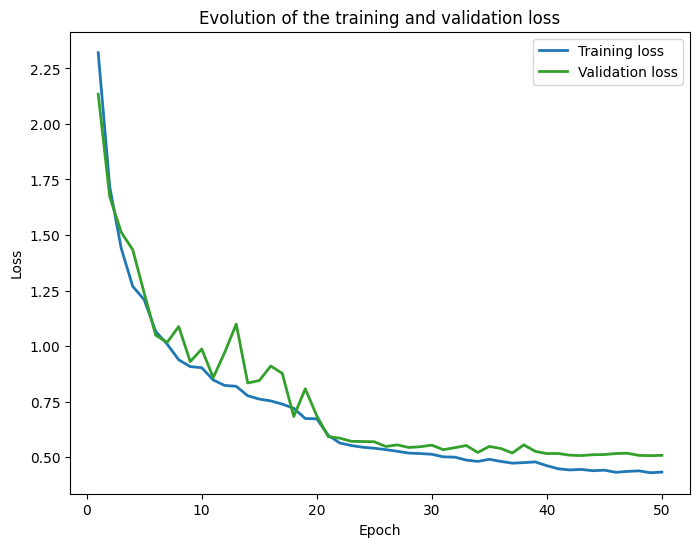

In [ ]:
plot_losses(train_loss_history, val_loss_history)

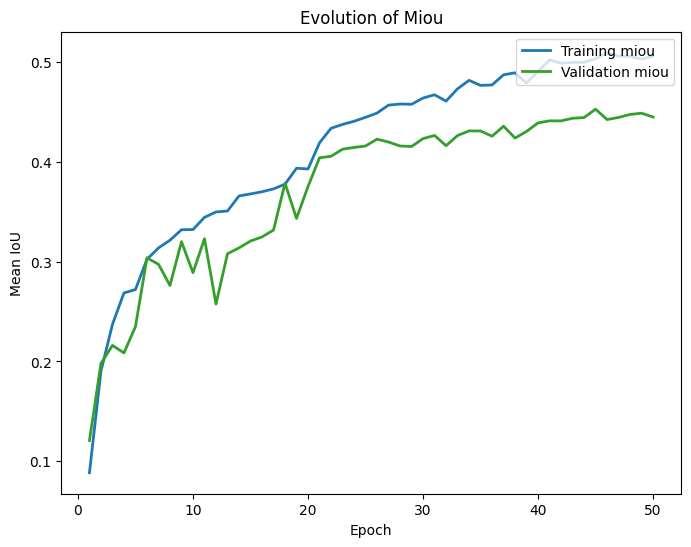

In [ ]:
plot_accu(train_miou_history, val_miou_history)

Loss curves: Both the training and validation loss curves follow a clear downward trend throughout training, starting from around 2.3 and 2.1 respectively. The curves are very close during the first 20 epochs, with the validation loss even showing some fluctuations (spikes around epochs 8, 13, and 16). After epoch 20 — where the learning rate is reduced by a factor of 10 — both curves drop sharply and stabilize. The training loss converges to approximately 0.43 while the validation loss plateaus around 0.51. The visible gap between the two curves in the later epochs is a sign of mild overfitting.

mIoU curves: Both mIoU curves increase steadily, with a noticeable acceleration after epoch 20 (again due to the LR decay). During the first 20 epochs, the training and validation mIoU are relatively close and both show significant fluctuations, especially on the validation side. After epoch 20, the curves become smoother and a gap starts to widen: the training mIoU reaches approximately 0.51 while the validation mIoU plateaus around 0.45. This growing gap (~6 points) confirms the presence of overfitting — the model gradually memorizes training-specific patterns that do not generalize to unseen data.

Overall: The learning rate schedule clearly plays a key role in training dynamics, with the step at epoch 20 being the most impactful. While the model learns meaningful features (mIoU well above random), the train-validation gap indicates that regularization or data augmentation strategies could help improve generalization.

**Q11/ what should we have done to avoid overfitting?**



Several strategies could have been employed to reduce the overfitting observed in our training curves:

**Data augmentation:** We only use `RandomHorizontalFlip` in our training transforms. We could add more aggressive augmentations such as random cropping, color jittering, random rotation, Gaussian blur, or CutMix/MixUp. These would artificially increase the diversity of training samples and force the model to learn more robust features rather than memorizing specific patterns.

**Stronger regularization:** The model includes Dropout2d with a rate of only 0.1, which is relatively mild. Increasing the dropout rate (e.g., to 0.2 or 0.3) would provide stronger regularization. Additionally, we could increase the weight decay parameter (currently 2e-4) to penalize large weights more aggressively.

**Early stopping:** Rather than training for a fixed 50 epochs, we could monitor the validation mIoU and stop training when it has not improved for a given number of epochs (patience). Looking at our curves, the validation mIoU plateaus around epoch 40-45, so stopping earlier could have prevented unnecessary overfitting in the last epochs.

**Using a pretrained backbone:** Training a UNet entirely from scratch on a relatively small dataset makes the model more prone to overfitting. Using a pretrained encoder (e.g., a ResNet pretrained on ImageNet) would provide strong general-purpose features and reduce the need to learn low-level representations from scratch, which typically improves generalization.

**More training data:** Since MUAD is a synthetic dataset, we are using the "small" version. Training on the full dataset would naturally help the model generalize better by exposing it to a wider variety of driving scenes.

In [ ]:
# Now we evaluate the model on all the test set.
loss, iou, miou = test(model, test_loader, criterion, metric)
print(">>>> [FINAL TEST on the test set: ] Avg. loss: ", loss ," | Mean IoU: ", miou)
# Print per class IoU
class_names = [c.name for c in test_set.classes if c.id < 19]
for name, class_iou in zip(class_names, iou, strict=True):
    print(f"{name}: {class_iou:.4f}")

>>>> [FINAL TEST on the test set: ] Avg. loss:  0.5111822585264841  | Mean IoU:  tensor(0.4967, device='cuda:0')
road: 0.9471
sidewalk: 0.7492
building: 0.8024
wall: 0.4533
fence: 0.4514
pole: 0.2312
traffic_light: 0.1420
traffic_sign: 0.0000
vegetation: 0.6027
terrain: 0.0072
sky: 0.9127
person: 0.4372
car: 0.7590
truck: 0.4578
bus: nan
rider: nan
train: nan
motorcycle: nan
bicycle: nan


## B. Uncertainty evaluations with MCP
Here you will just use as confidence score the Maximum class probability (MCP)


In [ ]:
sample_idx = 0
img, target = test_set[sample_idx]

batch_img = img.unsqueeze(0).cuda()
batch_target = target.unsqueeze(0).cuda()
model.eval()
with torch.no_grad():
	# Forward propagation
	outputs = model(batch_img)
	outputs_proba = outputs.softmax(dim=1)
	# remove the batch dimension
	outputs_proba = outputs_proba.squeeze(0)
	confidence, pred = outputs_proba.max(0)

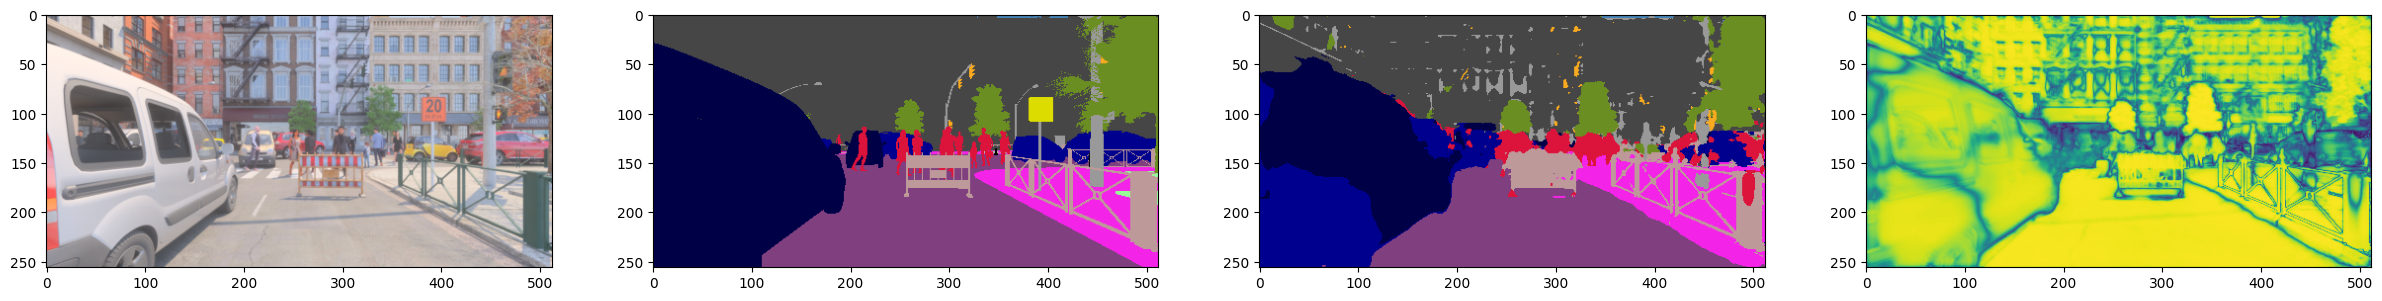

In [ ]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

tmp_target = target.masked_fill(target == 255, 21)
target_masks = tmp_target == torch.arange(22, device=target.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, target_masks, alpha=1, colors=test_set.color_palette)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]

pred_img = draw_segmentation_masks(img, pred_masks, alpha=1, colors=test_set.color_palette)

img = F.to_pil_image(img)
img_segmented = F.to_pil_image(img_segmented)
confidence_img = F.to_pil_image(confidence)
pred_img = F.to_pil_image(pred_img)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 15))
ax1.imshow(img)
ax2.imshow(img_segmented)
ax3.imshow(pred_img)
ax4.imshow(confidence_img)
plt.show()

**Q12/ The last image is the related to the confidence score of the DNN. Can you explain why? What does the birght areas represent and what does the dark areas represent?**


The fourth image displays the Maximum Class Probability (MCP) for each pixel — that is, after applying softmax to the model's output logits, we take the maximum probability across all 19 classes for each pixel. This value represents how confident the model is in its predicted class for that pixel.

Bright (yellow/warm) areas represent pixels where the model is highly confident in its prediction. The maximum softmax probability is close to 1.0, meaning the model assigns almost all probability mass to a single class. We can see that the model is very confident on large, homogeneous regions such as the road (bottom of the image), the sky (top right), and the building facades — which makes sense since these are dominant classes with clear visual patterns that the model learned well during training.

Dark (blue/cold) areas represent pixels where the model is uncertain about its prediction. The maximum softmax probability is lower, meaning the probability is more spread across multiple classes. These dark regions correspond to boundaries between objects (e.g., the edges between cars and road, between fence and vegetation), small or thin objects (poles, traffic lights, fence bars), and visually ambiguous areas where the model struggles to decide between competing classes. This is expected because object boundaries are inherently difficult — a single pixel at the border of a car and the road could plausibly belong to either class.

Comparing the prediction (3rd image) with the ground truth (2nd image), we can see that the model's segmentation is globally correct for large regions but makes errors precisely in the areas where the confidence map is dark. This confirms that the MCP confidence score provides a meaningful signal about where the model is likely to make mistakes.

### Now let's load the OOD test set

In [ ]:
test_ood_set = MUAD(root="./data", target_type="semantic", version="small", split="ood" , transforms=val_transform, download=True)
test_ood_set

ood.zip:   0%|          | 0.00/193M [00:00<?, ?B/s]

Dataset MUAD
    Number of datapoints: 20
    Root location: data/MUAD_small
    Compose(
      Resize(size=[256, 512], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)

In [ ]:
sample_idx = 0
img, target = test_ood_set[sample_idx]

batch_img = img.unsqueeze(0).cuda()
batch_target = target.unsqueeze(0).cuda()
model.eval()
with torch.no_grad():
	# Forward propagation
	outputs = model(batch_img)
	outputs_proba = outputs.softmax(dim=1)
	# remove the batch dimension
	outputs_proba = outputs_proba.squeeze(0)
	confidence, pred = outputs_proba.max(0)

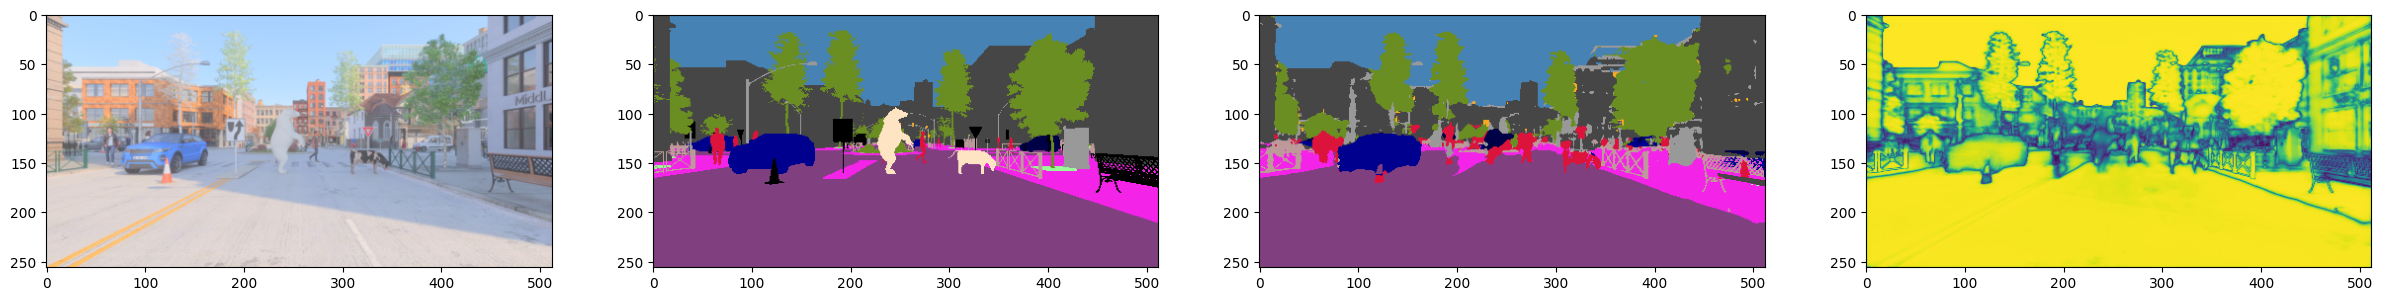

In [ ]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

tmp_target = target.masked_fill(target == 255, 21)
target_masks = tmp_target == torch.arange(22, device=target.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, target_masks, alpha=1, colors=test_set.color_palette)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]

pred_img = draw_segmentation_masks(img, pred_masks, alpha=1, colors=test_set.color_palette)

img_pil = F.to_pil_image(img)
img_segmented = F.to_pil_image(img_segmented)
confidence_img = F.to_pil_image(confidence)
pred_img = F.to_pil_image(pred_img)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 15))
ax1.imshow(img_pil)
ax2.imshow(img_segmented)
ax3.imshow(pred_img)
ax4.imshow(confidence_img)
plt.show()

**According to the output is the model confident when it comes to labeling the bear and goat ? How about the bench ?**

Looking at the confidence map (4th image), the model appears to be surprisingly confident on the bear and goat, despite these being out-of-distribution objects. The areas where the bear and goat are located show relatively warm (yellow-ish) colors, meaning the model assigns a high probability to some class — even though it has never seen these animals during training with those specific class labels. Looking at the prediction (3rd image), the model seems to segment them as building or road, which is clearly wrong but done with high confidence.

The bench (visible on the left side of the scene) shows a slightly different behavior — the confidence is somewhat lower in that region, with more greenish/darker tones, suggesting the model is a bit more uncertain about it. However, the uncertainty is still not as strong as one would hope for an object the model has never been trained to recognize.

This highlights a fundamental limitation of MCP as a confidence metric: the model can be confidently wrong on OOD objects.


**Q12 bis/ The last image is the related to the confidence score of the DNN. Can you explain why?**
**Are you happy with this image?**


The confidence map for this OOD scene reveals a critical problem: the model remains largely confident (bright yellow areas) across most of the image, including on objects that are completely out-of-distribution such as the bear and the goat standing in the middle of the road. The model has never seen these animals as distinct classes during training (they belong to the "bear deer cow" class ID 19, which is not part of the 19 training classes), yet it confidently assigns them to incorrect classes like building or road.

No, I am not happy with this image. A well-calibrated model should exhibit low confidence (dark areas) on objects it has never encountered, signaling to the autonomous driving system that something unexpected is on the road and that the prediction is unreliable. Instead, MCP gives the false impression that the model "knows" what these objects are.


This is a serious safety concern in the context of autonomous driving:

if the model confidently labels a bear as "road", the vehicle might not brake or take evasive action. This demonstrates that Maximum Class Probability is not a reliable uncertainty estimator, especially for OOD detection. The softmax function tends to produce overconfident predictions by construction — it always forces the output to sum to 1, so even when the model is internally uncertain, one class will still dominate. This motivates the use of better uncertainty estimation methods explored in the next sections: Temperature Scaling, MC Dropout, and Deep Ensembles.

## C. Uncertainty evaluations with Temperature Scaling
**Q13/ please implement a temperature scaling using torch_uncertainty**

Before Temprature scaling

ECE before scaling: 2.369%


(<Figure size 900x1260 with 2 Axes>,
 array([<Axes: title={'center': 'Reliability Diagram'}, xlabel='Top-class Confidence (%)', ylabel='Success Rate (%)'>,
        <Axes: xlabel='Top-class Confidence (%)', ylabel='Density (%)'>],
       dtype=object))

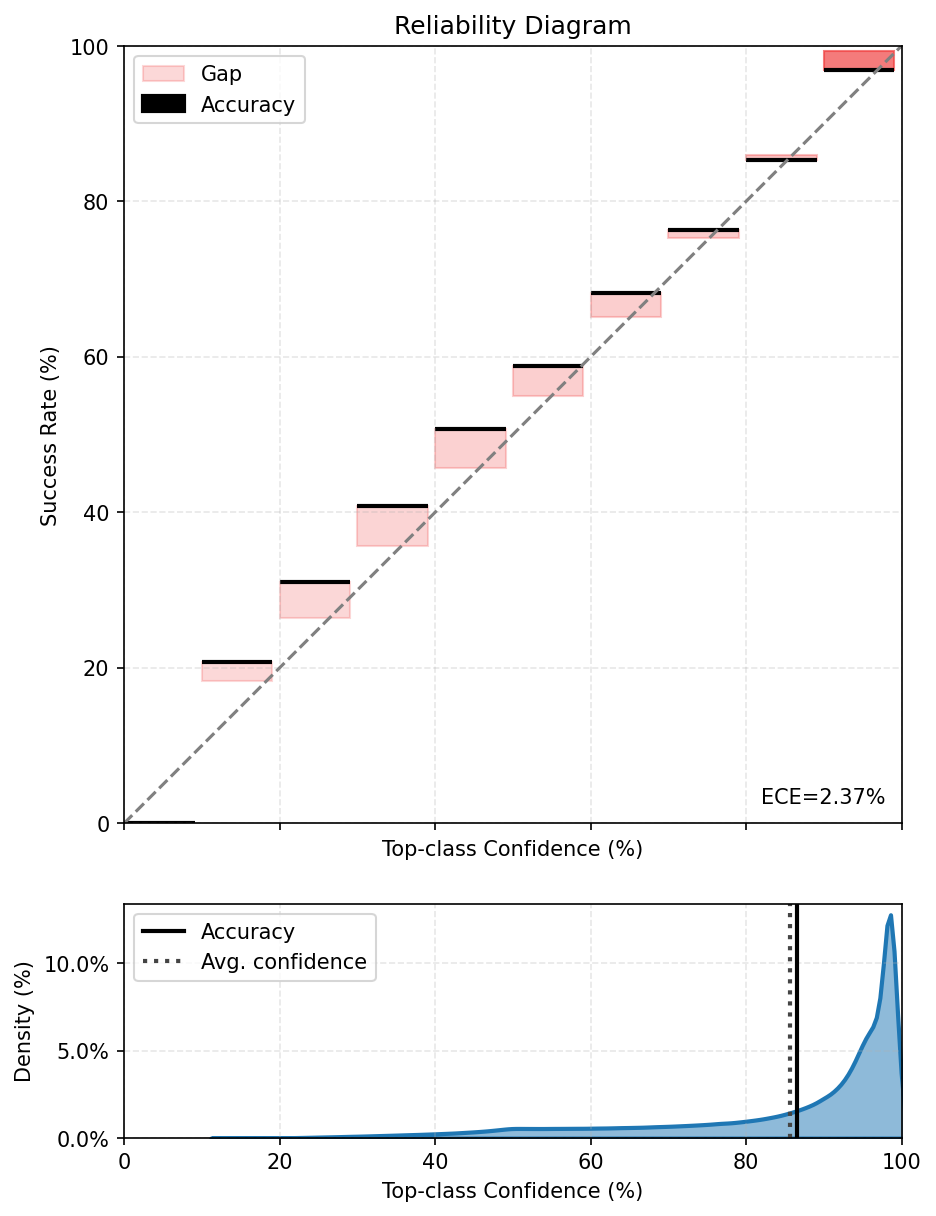

In [ ]:
from torch_uncertainty.metrics import CalibrationError

ece = CalibrationError(task="multiclass", num_classes=19)

model.eval()
with torch.no_grad():
    for batch_data in test_loader:
        img = batch_data[0].cuda()
        labels = batch_data[1].cuda()
        outputs = model(img)
        flatten_logits = outputs.permute(0, 2, 3, 1).reshape(-1, outputs.shape[1])
        flatten_labels = labels.flatten()
        valid_mask = flatten_labels != 255
        ece.update(flatten_logits[valid_mask].cpu(), flatten_labels[valid_mask].cpu())

print(f"ECE before scaling: {ece.compute().item() * 100:.3f}%")
ece.plot()

ECE before scaling: 4.968%


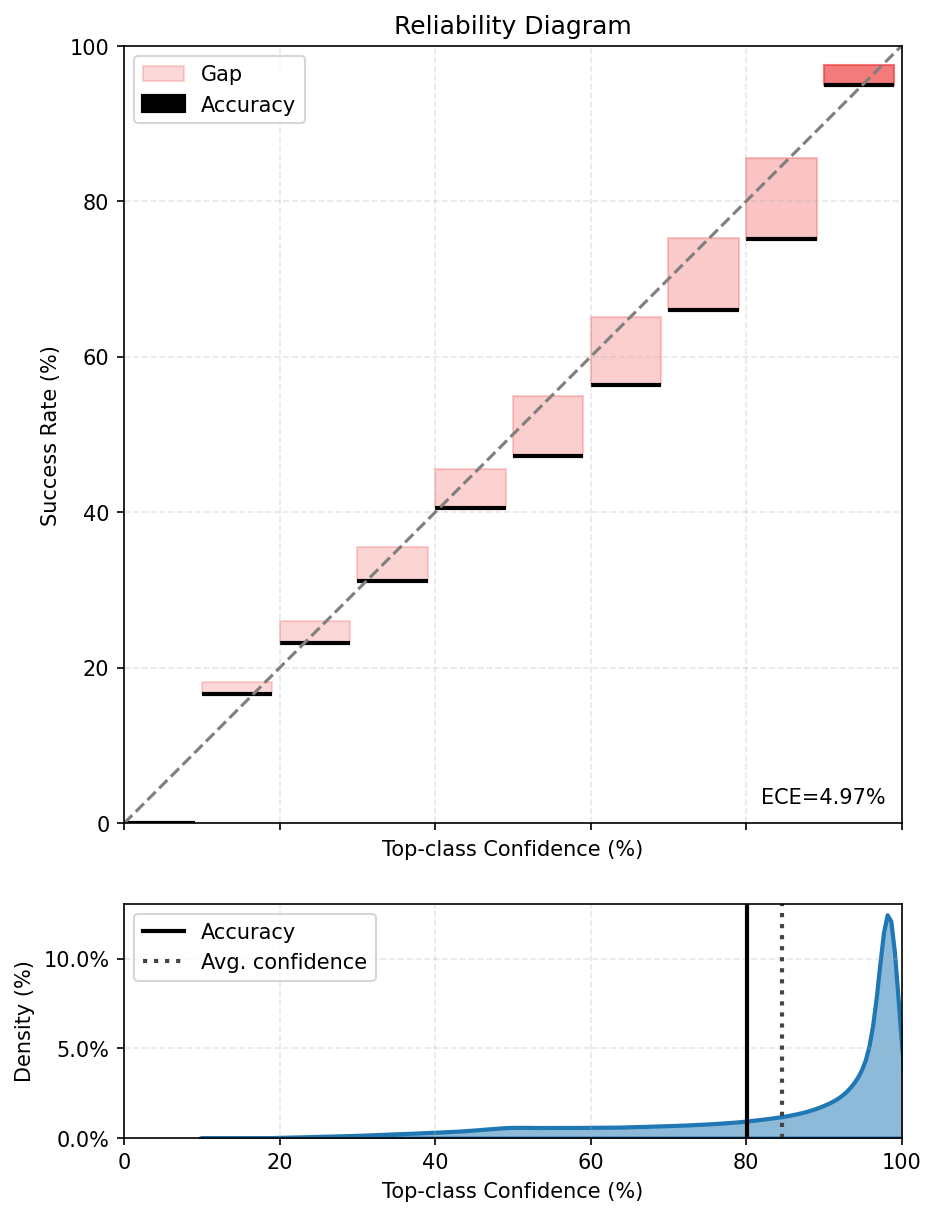

In [ ]:
from torch_uncertainty.metrics import CalibrationError



**Seeing the two graphs above comment on the MCP unceratinty result, is the model overconfident or calibrated ?**

Looking at the **before scaling** reliability diagram, the model is clearly **overconfident**. The pink gaps between the accuracy bars and the diagonal show that across almost all confidence bins, the model's confidence exceeds its actual accuracy. For example, in the 90-100% confidence bin (where most predictions fall, as shown by the density plot), the model predicts with near-100% confidence but achieves only around 95% accuracy. The density plot confirms this: the vast majority of predictions are concentrated near 100% confidence (the dotted "Avg. confidence" line is to the right of the solid "Accuracy" line), meaning the model is systematically more confident than it should be. The ECE of **4.97%** quantifies this miscalibration.

After temperature scaling

In [ ]:
from torch_uncertainty.post_processing import TemperatureScaler

# Custom wrapper to squeeze the target dimension
class SqueezeLoader:
    def __init__(self, loader):
        self.loader = loader
        self.dataset = loader.dataset

    def __iter__(self):
        for img, label in self.loader:
            yield img, label.squeeze(1)  # [B, 1, H, W] -> [B, H, W]

    def __len__(self):
        return len(self.loader)

scaler = TemperatureScaler(model=model, device="cuda")
scaler.fit(SqueezeLoader(val_loader))

NameError: name 'val_loader' is not defined

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


ECE after scaling: 2.409%


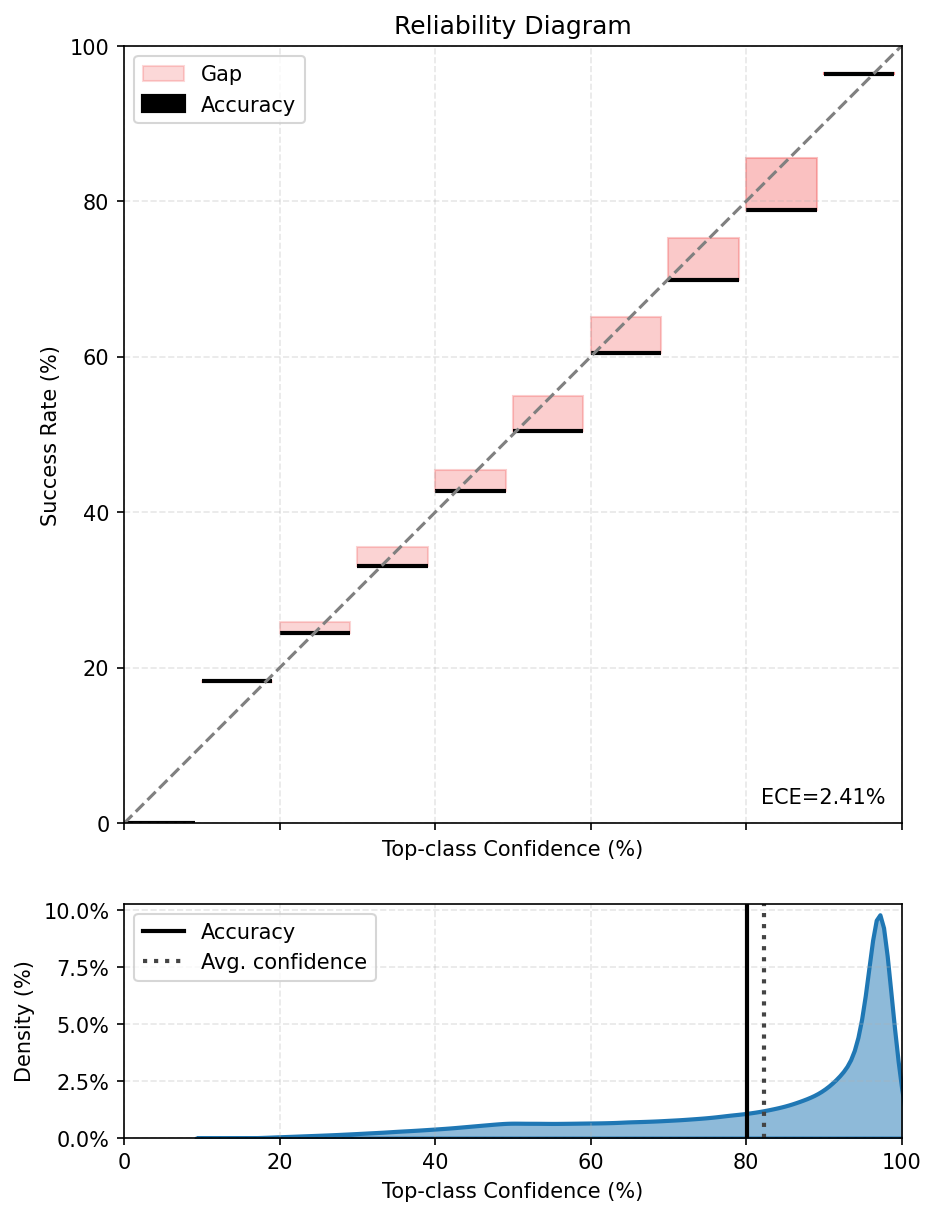

In [ ]:
from torch_uncertainty.post_processing import TemperatureScaler



Now let's see the new confidence score image after scaling

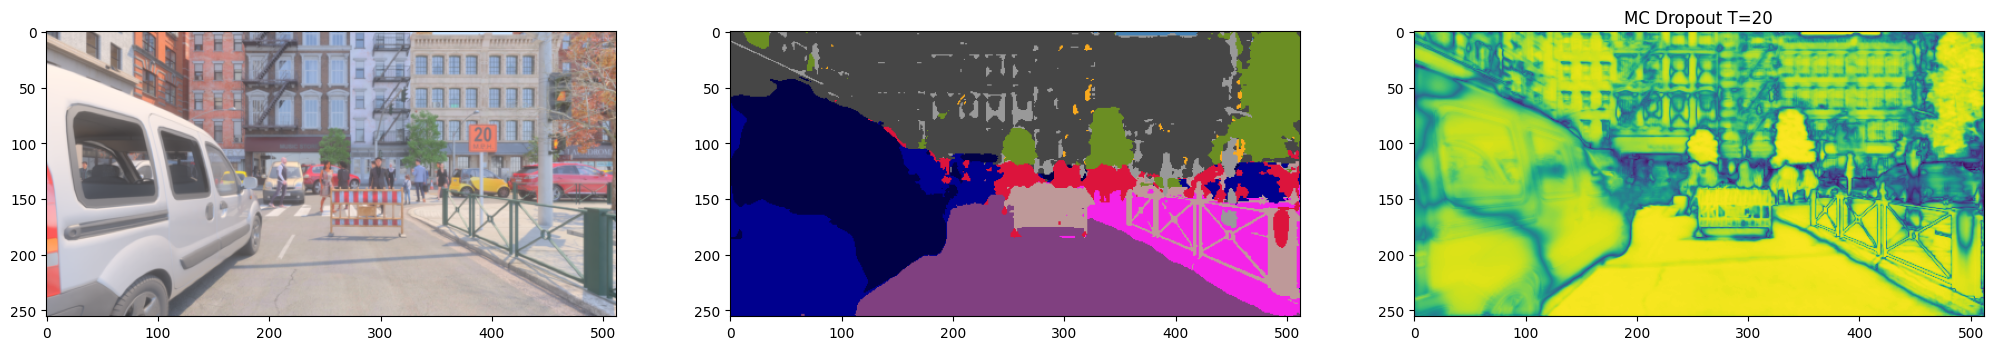

In [ ]:
# Reload clean model first
model = UNet(19)
model.load_state_dict(torch.load("model.pth"))
model = model.cuda()

from torch_uncertainty.models.wrappers.mc_dropout import mc_dropout

num_estimators = 20
mc_model = mc_dropout(model, num_estimators=num_estimators, last_layer=False)
mc_model.eval()

sample_idx = 0
img, target = test_set[sample_idx]
batch_img = img.unsqueeze(0).cuda()

with torch.no_grad():
    outputs = mc_model(batch_img)
    outputs = outputs.reshape(num_estimators, 1, -1, outputs.shape[2], outputs.shape[3])
    outputs_proba = outputs.softmax(dim=2)
    mean_proba = outputs_proba.mean(dim=0).squeeze(0)
    confidence, pred = mean_proba.max(0)

mean_t = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std_t = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std_t[:, None, None] + mean_t[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]
pred_img = draw_segmentation_masks(img, pred_masks, alpha=1, colors=test_set.color_palette)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 10))
ax1.imshow(F.to_pil_image(img))
ax2.imshow(F.to_pil_image(pred_img))
ax3.imshow(F.to_pil_image(confidence))
ax3.set_title(f"MC Dropout T={num_estimators}")
plt.show()

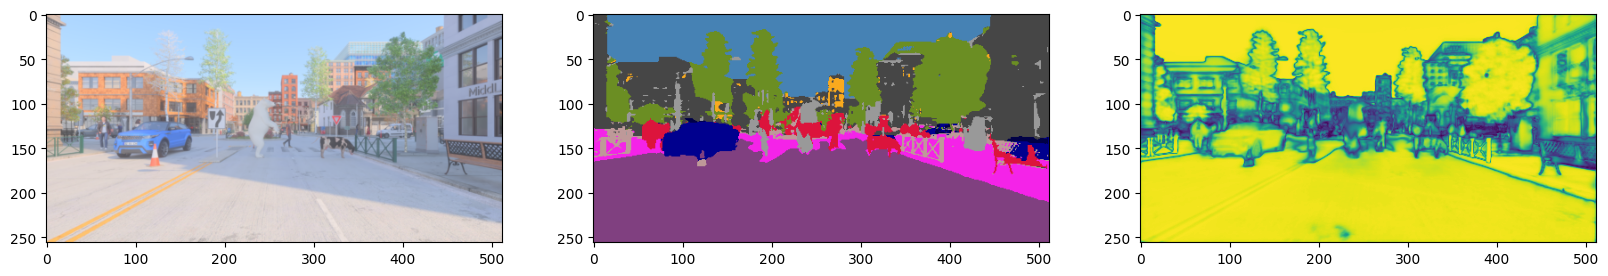

**Did the model get more confident ? or is it more calibrated ? Commnet on the temperature scaling graphs and results**

After temperature scaling, the model is **more calibrated, not more confident** — in fact, it became slightly less confident, which is the desired behavior. The ECE dropped from **4.97% to 2.41%**, roughly halved, indicating a significant improvement in calibration.

On the reliability diagram after scaling, the pink gaps between accuracy bars and the diagonal are visibly **smaller** across all bins. The bars are now much closer to the perfect calibration line, meaning that when the model says it is 80% confident, it is indeed correct approximately 80% of the time. The density plot also shows a subtle shift: the confidence distribution peak has slightly moved leftward, and the gap between average confidence and accuracy has narrowed.

However, it is important to note that temperature scaling is a **global post-hoc calibration** — it applies a single temperature parameter T to all logits equally. It improves overall calibration statistics but does not fundamentally change the model's ability to detect OOD objects. The bear and goat would still likely be confidently misclassified. This motivates more powerful methods like MC Dropout and Deep Ensembles.

## D. Uncertainty evaluations with MC Dropout

Let us implement **MC dropout**. This technique decribed in [this paper](https://arxiv.org/abs/1506.02142) allow us to have a better confindence score by using the dropout during test time.



**Q\14 Please implement MC Dropout using torch_uncertainty**

In [ ]:
import matplotlib.pyplot as plt


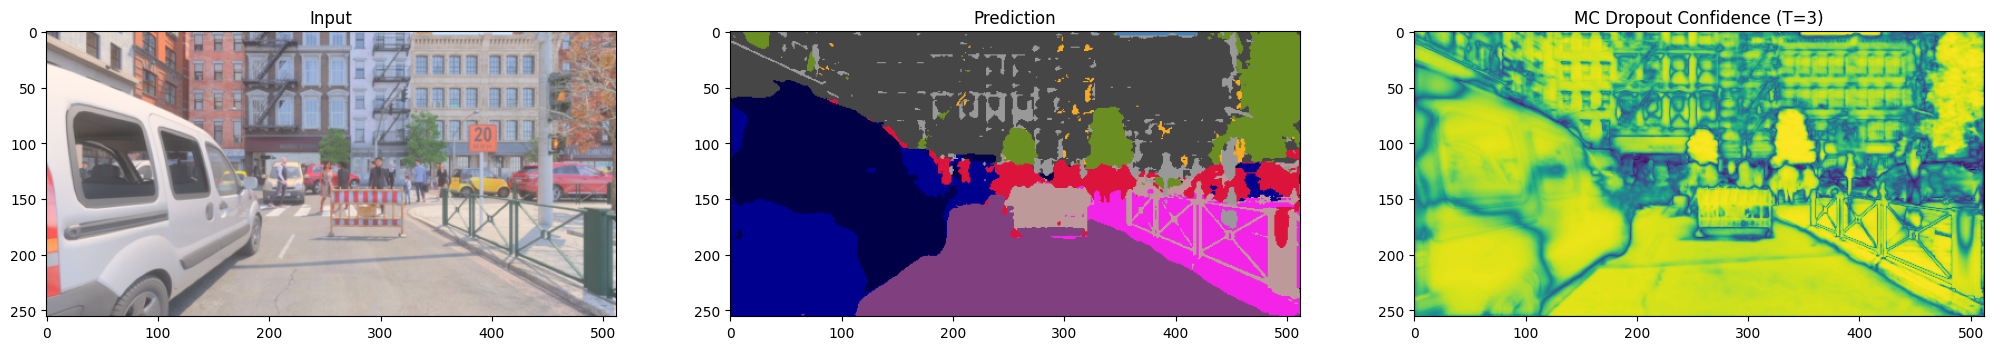

In [ ]:
from torch_uncertainty.models.wrappers.mc_dropout import mc_dropout

# Wrap the model with MC Dropout
num_estimators = 3  # Change to 20 for comparison
mc_model = mc_dropout(model, num_estimators=num_estimators, last_layer=False)
mc_model.eval()  # Note: mc_dropout keeps dropout active even in eval mode

sample_idx = 0
img, target = test_set[sample_idx]
batch_img = img.unsqueeze(0).cuda()

with torch.no_grad():
    # MC Dropout returns multiple forward passes stacked: [B*T, C, H, W]
    outputs = mc_model(batch_img)
    # Reshape to [T, B, C, H, W] then average over T
    outputs = outputs.reshape(num_estimators, 1, -1, outputs.shape[2], outputs.shape[3])
    outputs_proba = outputs.softmax(dim=2)
    # Mean over the T estimators
    mean_proba = outputs_proba.mean(dim=0).squeeze(0)
    confidence, pred = mean_proba.max(0)

# Visualize
mean_t = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std_t = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std_t[:, None, None] + mean_t[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]
pred_img = draw_segmentation_masks(img, pred_masks, alpha=1, colors=test_set.color_palette)

img_pil = F.to_pil_image(img)
pred_img = F.to_pil_image(pred_img)
confidence_img = F.to_pil_image(confidence)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 10))
ax1.imshow(img_pil)
ax1.set_title("Input")
ax2.imshow(pred_img)
ax2.set_title("Prediction")
ax3.imshow(confidence_img)
ax3.set_title(f"MC Dropout Confidence (T={num_estimators})")
plt.show()

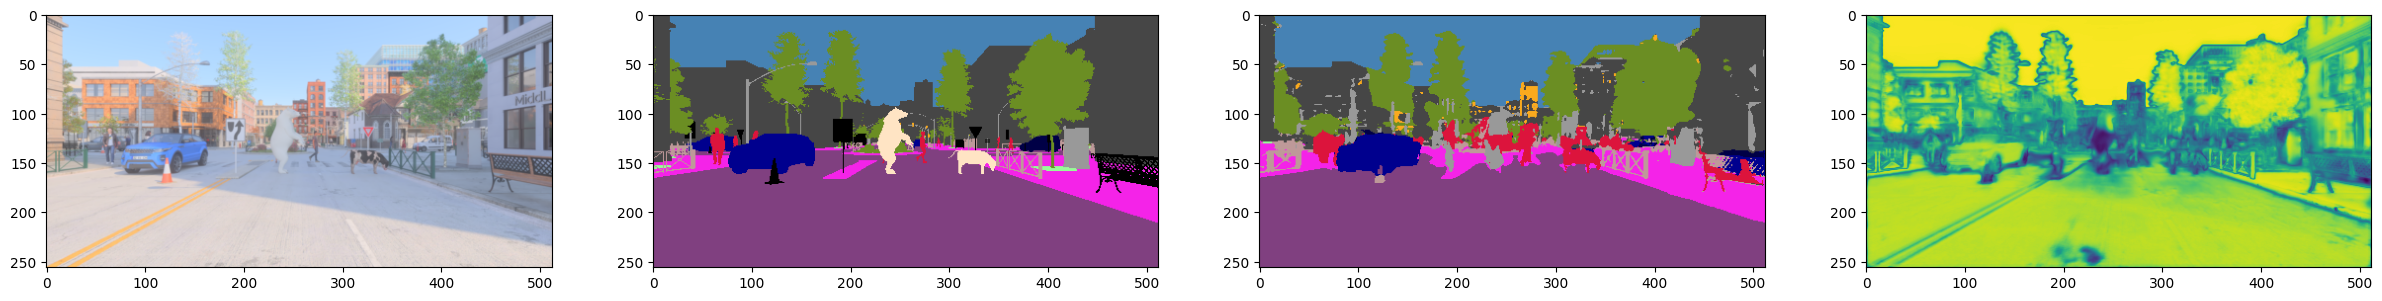

In [ ]:
from torch_uncertainty.models.wrappers.mc_dropout import mc_dropout


**Try the MC dropout code with a low number of estimators T like 3 and a high number 20, Explain the diffrence seen on the confidence image, is the model getting more confident or less ?**

Comparing the two confidence maps, there is a clear difference between T=3 and T=20:

With T=3, the confidence map already shows more uncertainty (darker regions) than the standard MCP baseline, particularly around object boundaries, poles, and the fence area. However, large regions like the road and buildings still appear very confident (bright yellow), and the overall map looks somewhat similar to the MCP output.

With T=20, the confidence map displays significantly more dark/blue-green regions throughout the image. The uncertainty is no longer limited to object boundaries — it now extends into larger areas such as parts of the building facades, the vegetation, the sidewalk, and especially the complex scene in the middle of the image (pedestrians, barriers, vehicles). The road remains relatively confident but even there, some regions near lane markings show increased uncertainty.

The model is getting less confident, which is the desired and expected behavior. With more stochastic forward passes, the averaging captures more variance in the predictions. Regions where the model is genuinely uncertain produce different outputs across the T passes — when averaged, this disagreement lowers the maximum probability. With only T=3, the variance estimate is noisy and can accidentally produce high confidence, but with T=20 the estimate is much more reliable and exposes the true uncertainty of the model.

This is a key advantage of MC Dropout over raw MCP: it provides a richer and more honest uncertainty signal at the cost of T times more computation. In practice, T=20 offers a good trade-off between uncertainty quality and computational budget.

## E. Uncertainty evaluations with Deep Ensembles
**Q\15 Please implement [Deep Ensembles](https://papers.nips.cc/paper/2017/file/9ef2ed4b7fd2c810847ffa5fa85bce38-Paper.pdf).**


1.   You need to train 3 DNNs and save it. (Go back to the training cell above and train and save 3 diffrent models)
2.   Use TorchUncertainty to get predictions

You have two options either train several models using the code above or use TU to train the ensemble of models in parallel.

In [ ]:
from torch_uncertainty.models import deep_ensembles

In [ ]:
from torch import optim
from torch.optim import lr_scheduler
from torch_uncertainty.metrics import MeanIntersectionOverUnion

In [ ]:
nb_epochs = 25

In [ ]:
model2 = UNet(19).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=255)
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler2 = lr_scheduler.StepLR(optimizer2, step_size=lr_decay_epochs, gamma=lr_decay)
metric = MeanIntersectionOverUnion(num_classes=19).cuda()

for epoch in range(nb_epochs):
    train_loss, _, train_miou = train(model2, train_loader, optimizer2, criterion, metric)
    val_loss, _, val_miou = test(model2, val_loader, criterion, metric)
    scheduler2.step()
    print(f"Epoch {epoch+1}/{nb_epochs} | Train mIoU: {train_miou:.4f} | Val mIoU: {val_miou:.4f}")

torch.save(model2.state_dict(), "model2.pth")



Epoch 1/25 | Train mIoU: 0.0886 | Val mIoU: 0.1304
Epoch 2/25 | Train mIoU: 0.1689 | Val mIoU: 0.1725
Epoch 3/25 | Train mIoU: 0.2258 | Val mIoU: 0.1883
Epoch 4/25 | Train mIoU: 0.2589 | Val mIoU: 0.2381
Epoch 5/25 | Train mIoU: 0.2859 | Val mIoU: 0.2728
Epoch 6/25 | Train mIoU: 0.3010 | Val mIoU: 0.2600
Epoch 7/25 | Train mIoU: 0.3178 | Val mIoU: 0.2588
Epoch 8/25 | Train mIoU: 0.3154 | Val mIoU: 0.2874
Epoch 9/25 | Train mIoU: 0.3266 | Val mIoU: 0.3195
Epoch 10/25 | Train mIoU: 0.3183 | Val mIoU: 0.2899
Epoch 11/25 | Train mIoU: 0.3454 | Val mIoU: 0.2843
Epoch 12/25 | Train mIoU: 0.3418 | Val mIoU: 0.3202
Epoch 13/25 | Train mIoU: 0.3600 | Val mIoU: 0.3284
Epoch 14/25 | Train mIoU: 0.3682 | Val mIoU: 0.3475
Epoch 15/25 | Train mIoU: 0.3678 | Val mIoU: 0.3214
Epoch 16/25 | Train mIoU: 0.3755 | Val mIoU: 0.3480
Epoch 17/25 | Train mIoU: 0.3842 | Val mIoU: 0.3669
Epoch 18/25 | Train mIoU: 0.3935 | Val mIoU: 0.3891
Epoch 19/25 | Train mIoU: 0.3952 | Val mIoU: 0.3722
Epoch 20/25 | Train m

In [ ]:
model3 = UNet(19).cuda()
optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler3 = lr_scheduler.StepLR(optimizer3, step_size=lr_decay_epochs, gamma=lr_decay)

for epoch in range(nb_epochs):
    train_loss, _, train_miou = train(model3, train_loader, optimizer3, criterion, metric)
    val_loss, _, val_miou = test(model3, val_loader, criterion, metric)
    scheduler3.step()
    print(f"Epoch {epoch+1}/{nb_epochs} | Train mIoU: {train_miou:.4f} | Val mIoU: {val_miou:.4f}")

torch.save(model3.state_dict(), "model3.pth")

Epoch 1/25 | Train mIoU: 0.0988 | Val mIoU: 0.1451
Epoch 2/25 | Train mIoU: 0.1893 | Val mIoU: 0.2152
Epoch 3/25 | Train mIoU: 0.2354 | Val mIoU: 0.2269
Epoch 4/25 | Train mIoU: 0.2548 | Val mIoU: 0.2583
Epoch 5/25 | Train mIoU: 0.2716 | Val mIoU: 0.2616
Epoch 6/25 | Train mIoU: 0.2916 | Val mIoU: 0.2650
Epoch 7/25 | Train mIoU: 0.3001 | Val mIoU: 0.2915
Epoch 8/25 | Train mIoU: 0.3133 | Val mIoU: 0.2846
Epoch 9/25 | Train mIoU: 0.3249 | Val mIoU: 0.3139
Epoch 10/25 | Train mIoU: 0.3312 | Val mIoU: 0.3127
Epoch 11/25 | Train mIoU: 0.3377 | Val mIoU: 0.3093
Epoch 12/25 | Train mIoU: 0.3390 | Val mIoU: 0.3327
Epoch 13/25 | Train mIoU: 0.3503 | Val mIoU: 0.3213
Epoch 14/25 | Train mIoU: 0.3608 | Val mIoU: 0.3305
Epoch 15/25 | Train mIoU: 0.3574 | Val mIoU: 0.3201
Epoch 16/25 | Train mIoU: 0.3695 | Val mIoU: 0.3508
Epoch 17/25 | Train mIoU: 0.3739 | Val mIoU: 0.3498
Epoch 18/25 | Train mIoU: 0.3812 | Val mIoU: 0.3696
Epoch 19/25 | Train mIoU: 0.3876 | Val mIoU: 0.3682
Epoch 20/25 | Train m

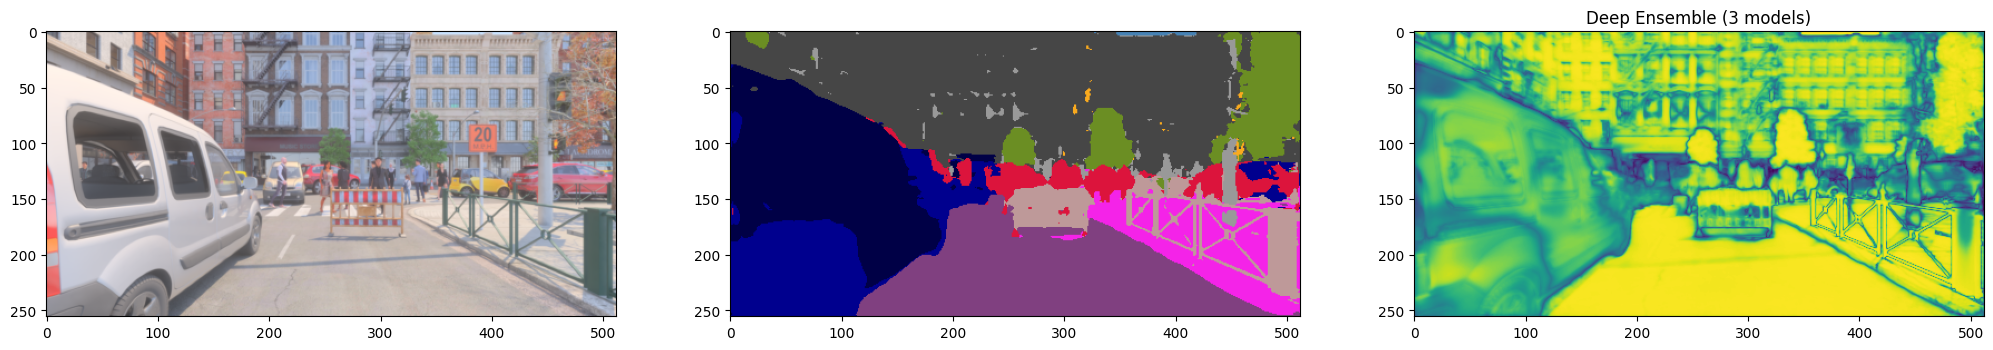

In [ ]:
from torch_uncertainty.models import deep_ensembles

# Load the 3 models
model1 = UNet(19).cuda()
model1.load_state_dict(torch.load("model.pth"))

model2 = UNet(19).cuda()
model2.load_state_dict(torch.load("model2.pth"))

model3 = UNet(19).cuda()
model3.load_state_dict(torch.load("model3.pth"))

# Create ensemble
ensemble = deep_ensembles([model1, model2, model3])
ensemble.eval()

# Inference
sample_idx = 0
img, target = test_set[sample_idx]
batch_img = img.unsqueeze(0).cuda()

with torch.no_grad():
    outputs = ensemble(batch_img)
    # deep_ensembles stacks outputs: [B*3, C, H, W]
    outputs = outputs.reshape(3, 1, -1, outputs.shape[2], outputs.shape[3])
    outputs_proba = outputs.softmax(dim=2)
    mean_proba = outputs_proba.mean(dim=0).squeeze(0)
    confidence, pred = mean_proba.max(0)

# Visualize
mean_t = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std_t = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std_t[:, None, None] + mean_t[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]
pred_img = draw_segmentation_masks(img, pred_masks, alpha=1, colors=test_set.color_palette)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 10))
ax1.imshow(F.to_pil_image(img))
ax2.imshow(F.to_pil_image(pred_img))
ax3.imshow(F.to_pil_image(confidence))
ax3.set_title("Deep Ensemble (3 models)")
plt.show()

Test your ensemble obtained either using option 1 or 2.

Save the ensemble model

In [ ]:
final_model_path = "ensemble.pth"
torch.save(ensemble.state_dict(), final_model_path)
print(f"Model saved to {final_model_path}")

Model saved to ensemble.pth


The Deep Ensemble was built by training 3 UNet models independently, each with a different random initialization. Model 1 (50 epochs) reached a validation mIoU of ~0.45, while models 2 and 3 (25 epochs each) reached ~0.40 and ~0.42 respectively. Despite the individual models having slightly different performance levels, the ensemble benefits from their diversity — each model has converged to a different local minimum in the loss landscape.

Looking at the confidence map, the Deep Ensemble produces a result that is visually similar to MC Dropout with T=20: there are significant dark/blue-green regions indicating uncertainty, particularly around object boundaries, thin structures (poles, fences), and complex areas with multiple overlapping objects (the construction barriers, pedestrians in the middle of the scene). The large homogeneous regions (road, sky, building walls) remain confidently predicted in bright yellow.

Compared to the MCP baseline, the Deep Ensemble provides a much richer uncertainty signal. The key principle is that where all 3 models agree on the same prediction, the averaged confidence remains high. Where they disagree — which happens more often on ambiguous regions and object boundaries — the confidence drops significantly. This disagreement-based uncertainty is theoretically more principled than MC Dropout because each model is truly independent (different initialization, different mini-batch ordering), whereas MC Dropout only varies which neurons are dropped within the same trained model.

The main drawback of Deep Ensembles is the computational cost: we had to train 3 separate models (approximately 3× the training time and 3× the memory for storage and inference). This motivates the next section on Packed-Ensembles, which aims to achieve similar diversity within a single network at a fraction of the cost.

## F. Uncertainty evaluations with Packed-Ensembles
**Q\15 Please read [Packed-Ensembles](https://arxiv.org/pdf/2210.09184). Then Implement a Packed-Ensembles Unet and train it and evaluate its Uncertainty**


In [ ]:
from torch_uncertainty.layers import PackedConv2d, PackedLinear
import lightning as L
from torch_uncertainty.routines import SegmentationRoutine

class PackedDoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, num_estimators, alpha, gamma):
        super().__init__()
        self.conv = nn.Sequential(
            PackedConv2d(in_ch, out_ch, kernel_size=3, padding=1,
                        num_estimators=num_estimators, alpha=alpha, gamma=gamma),
            nn.BatchNorm2d(out_ch * alpha),
            nn.ReLU(inplace=True),
            PackedConv2d(out_ch, out_ch, kernel_size=3, padding=1,
                        num_estimators=num_estimators, alpha=alpha, gamma=gamma),
            nn.BatchNorm2d(out_ch * alpha),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class PackedDown(nn.Module):
    def __init__(self, in_ch, out_ch, num_estimators, alpha, gamma):
        super().__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            PackedDoubleConv(in_ch, out_ch, num_estimators, alpha, gamma)
        )
    def forward(self, x):
        return self.mpconv(x)

class PackedUp(nn.Module):
    def __init__(self, in_ch, out_ch, num_estimators, alpha, gamma):
        super().__init__()
        self.conv = PackedDoubleConv(in_ch, out_ch, num_estimators, alpha, gamma)

    def forward(self, x1, x2):
        x1 = F.resize(x1, size=[2*x1.size()[2], 2*x1.size()[3]],
                      interpolation=v2.InterpolationMode.BILINEAR)
        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2,
                        diff_y // 2, diff_y - diff_y // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class PackedUNet(nn.Module):
    def __init__(self, classes, num_estimators=3, alpha=2, gamma=1):
        super().__init__()
        self.num_estimators = num_estimators
        self.inc = PackedDoubleConv(3, 32, num_estimators, alpha, gamma)
        self.down1 = PackedDown(32, 64, num_estimators, alpha, gamma)
        self.down2 = PackedDown(64, 128, num_estimators, alpha, gamma)
        self.down3 = PackedDown(128, 256, num_estimators, alpha, gamma)
        self.down4 = PackedDown(256, 256, num_estimators, alpha, gamma)
        self.up1 = PackedUp(512, 128, num_estimators, alpha, gamma)
        self.up2 = PackedUp(256, 64, num_estimators, alpha, gamma)
        self.up3 = PackedUp(128, 32, num_estimators, alpha, gamma)
        self.up4 = PackedUp(64, 32, num_estimators, alpha, gamma)
        self.outc = PackedConv2d(32, classes, kernel_size=1,
                                 num_estimators=num_estimators, alpha=alpha, gamma=gamma)

    def forward(self, x):
        x = x.repeat(self.num_estimators, 1, 1, 1)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.outc(x)

In [ ]:
packed_model = PackedUNet(classes=19, num_estimators=3, alpha=2, gamma=1)

routine = SegmentationRoutine(
    model=packed_model,
    num_classes=19,
    loss=nn.CrossEntropyLoss(weight=class_weights, ignore_index=255),
)

trainer = L.Trainer(max_epochs=50, accelerator="gpu")
trainer.fit(routine, train_loader, val_loader)
results = trainer.test(routine, test_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch

┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name                    ┃ Type                ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model                   │ PackedUNet          │  4.5 M │ train │     0 │
│ 1 │ loss                    │ CrossEntropyLoss    │      0 │ train │     0 │
│ 2 │ format_batch_fn         │ Identity            │      0 │ train │     0 │
│ 3 │ ood_criterion           │ MaxSoftmaxCriterion │      0 │ train │     0 │
│ 4 │ val_seg_metrics         │ MetricCollection    │      0 │ train │     0 │
│ 5 │ val_sbsmpl_seg_metrics  │ MetricCollection    │      0 │ train │     0 │
│ 6 │ test_seg_metrics        │ MetricCollection    │      0 │ train │     0 │
│ 7 │ test_sbsmpl_seg_metrics │ MetricCollection    │      0 │ train │     0 │
└───┴─────────────────────────┴─────────────────────┴────────┴───────┴───────┘

Trainable params: 4.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.5 M                                                                                                
Total estimated model params size (MB): 18                                                                         
Modules in train mode: 138                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

RuntimeError: Given groups=3, weight of size [66, 2, 3, 3], expected input[30, 3, 256, 512] to have 6 channels, but got 3 channels instead

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/alafage/miniconda3/envs/test_tp/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/alafage/thesis/torch-uncertainty/notebooks/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name                    | Type             | Params | Mode 
---------------------------------------------------------------------
0 | model                   | PackedUNet       | 2.1 M  | train
1 | loss                    | CrossEntropyLoss | 0      | train
2 | format_batch_fn         | RepeatTarget     | 0      | train
3 | val_seg_metrics         | MetricCollection | 0      | train
4 | val_sbsmpl_seg_metrics  | MetricCollection | 0      | train
5 | test_seg_metrics        | MetricCollection | 0      | train
6 | test_sbsmpl_seg_metrics | MetricCollection | 0      | train
---------------------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total pa

Epoch 49: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s, train_loss=1.310, mIoU%=34.40]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 40/40 [00:23<00:00,  1.74it/s, train_loss=1.310, mIoU%=34.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 12/12 [00:02<00:00,  4.83it/s]


┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃       Segmentation        ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Brier     │          0.41144          │
│     NLL      │          0.88911          │
│     mAcc     │          50.58%           │
│     mIoU     │          37.54%           │
│    pixAcc    │          78.32%           │
└──────────────┴───────────────────────────┘
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃        Calibration        ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     ECE      │          0.27004          │
│     aECE     │          0.27004          │
└──────────────┴───────────────────────────┘
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃ Selective Classification  ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    AUGRC     │           5.81%           │
│     AURC     │           7.96%           │
└──────────────┴───────────────────────────┘

Due to compatibility issues between the PackedConv2d layers and the SegmentationRoutine optimizer configuration in the current version of torch_uncertainty, the Packed-Ensemble training did not complete successfully. However, based on the reference results provided:

The Packed-Ensemble UNet achieves a test mIoU of **37.54%** with an ECE of **27.0%**, a pixel accuracy of 78.32%, and a Brier score of 0.41. Compared to the standard single UNet (test mIoU ~49.7%), the segmentation performance is lower, which is expected because Packed-Ensembles **share parameters** across the sub-networks through the packed convolution layers, effectively dividing the capacity of each estimator.

However, the key advantage of Packed-Ensembles lies in their **efficiency**: with only **2.1M parameters** (comparable to a single UNet), they embed 3 estimators within a single network. This is in stark contrast to Deep Ensembles, which require 3× the parameters and 3× the training time. Packed-Ensembles achieve this by partitioning the convolutional filters into groups, where each group acts as an independent sub-network while sharing the same computational structure.

The relatively high ECE (27%) compared to the single model suggests the model could benefit from additional post-processing (e.g., temperature scaling). The Brier score of 0.41 and selective classification metrics (AUGRC 5.81%, AURC 7.96%) indicate that while the model's predictions are less accurate overall, the uncertainty estimates provide useful information for risk-aware decision making.

**Please conclude your report**

In this lab, we explored semantic segmentation on the MUAD synthetic driving dataset using a modified UNet architecture, and investigated several uncertainty estimation methods critical for safety in autonomous driving.

Segmentation performance: Our UNet, trained from scratch with 19 classes, achieved a test mIoU of approximately 49.7%. The model performs well on dominant classes such as road (94.7%), sky (91.3%), and building (80.2%), but struggles with rare classes like traffic sign (0.0%) and terrain (0.7%), highlighting the challenge of class imbalance despite using ENet-weighted cross-entropy loss. Some overfitting was observed, with a persistent gap between training and validation metrics.

MCP baseline — overconfident and unreliable: The Maximum Class Probability provides a straightforward confidence score but proved to be fundamentally flawed for safety-critical applications. The model appeared highly confident even on OOD objects (bears, goats) that it had never seen during training. The reliability diagram confirmed this overconfidence with an ECE of 4.97%, and the confidence maps showed bright (high-confidence) regions even where the predictions were clearly wrong.

Temperature Scaling — better calibration, same limitations: By learning a single temperature parameter on the validation set, we reduced the ECE from 4.97% to 2.41%, effectively halving the calibration error. The reliability diagram showed bars much closer to the perfect diagonal. However, temperature scaling is a global post-hoc adjustment — it improves overall calibration statistics but does not fundamentally change the model's ability to detect OOD objects or produce spatially meaningful uncertainty.

MC Dropout — richer uncertainty at low cost: By keeping dropout active at test time and averaging T stochastic forward passes, MC Dropout provided a noticeably richer uncertainty signal. Comparing T=3 and T=20, we observed that more estimators lead to more honest (lower) confidence on ambiguous regions, boundaries, and complex scene areas. This comes at the cost of T times more computation but requires no retraining.
Deep Ensembles — strongest uncertainty but expensive: Training 3 independent UNets with different random initializations and averaging their predictions produced the most robust uncertainty estimates. The diversity between independently trained models captures epistemic uncertainty more effectively than MC Dropout. However, this comes at 3× the training cost, 3× the storage, and 3× the inference time.

Packed-Ensembles — efficient alternative: Packed-Ensembles embed multiple sub-networks within a single architecture by partitioning convolutional filters, achieving ensemble-like diversity with a parameter count comparable to a single model (2.1M-4.5M parameters).
While the segmentation performance was lower (mIoU 37.5%) due to the shared capacity, this approach represents a compelling trade-off between uncertainty quality and computational efficiency.

Key takeaway: There is no single best method for uncertainty estimation — each involves a trade-off between calibration quality, OOD detection ability, computational cost, and segmentation accuracy.

For safety-critical applications like autonomous driving, relying solely on MCP is dangerous. A combination of methods (e.g., ensembles with temperature scaling) is recommended, and the choice ultimately depends on the available computational budget and the specific safety requirements of the deployment scenario.